In [98]:
# Standard Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import eli5

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as PipeImb
from imblearn.pipeline import make_pipeline


# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier


In [99]:
df=pd.read_csv(r"C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\Ironhack_final_project\Data\4a.IBM_data_cleaned_dropped_categorized - copy.csv")

# Standardizes data types

In [100]:
def a_xy_split(dataframe,y_name):
   
    #Get xy split and train/test data ready
    X = dataframe.drop([y_name], axis=1)
    y = dataframe.attrition
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    #Prep numerical and other column types for use in preprocessor
    numerical=X.select_dtypes(include='number')
    categorical=X.select_dtypes(include='object')
    numerical_columns=list(numerical.columns)
    categorical_columns=list(categorical.columns)
    columns=list(X.columns)
    cat_col_bool=[True if x in categorical_columns else False for x in columns]

    return X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool

In [101]:
def b_preprocessor():
    #Creating ss transformer to scale the continuous numerical data with StandardScaler()
    ss = Pipeline(steps=[('ss', StandardScaler())])
    #--------------------------------------------------------------------
    #Creating ohe transformer to encode the categorical data with OneHotEncoder()
    ohe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])
    #--------------------------------------------------------------------
    #Creating preprocess column transformer to combine the ss and ohe pipelines
    preprocess = ColumnTransformer(
                        transformers=[
                            ('num', ss, numerical_columns),
                            ('cat', ohe, categorical_columns)
                        ])
    return preprocess



In [102]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [103]:
def c_cross_validate(classifier, cv,conf_matrix=True):
    pipeline = PipeImb(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ])

    pipe_with_resample=make_pipeline(SMOTENC(categorical_features=X_train.dtypes==object,random_state=1234,n_jobs=-1),pipeline)
    train_acc = []
    train_rec=[]
    train_prec=[]
    test_acc = []
    test_rec=[]
    test_prec=[]
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipe_with_resample.fit(X_t, y_t)
        y_hat_t = pipe_with_resample.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        train_rec.append(recall_score(y_t,y_hat_t))
        train_prec.append(precision_score(y_t,y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipe_with_resample.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
        test_rec.append(recall_score(y_val, y_hat_val))
        test_prec.append(precision_score(y_val, y_hat_val))

    if conf_matrix==True:
        print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print("Training Recall: {}".format(np.mean(train_rec)))
    print("Training Precision: {}".format(np.mean(train_prec)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print("Validation Recall: {}".format(np.mean(test_rec)))
    print("Validation Precision: {}".format(np.mean(test_prec)))
    print('\n')


In [104]:
def c_grid_search(classifier, param_grid, cv, scoring="recall", print_feat=False):
    cv = cv
    search = GridSearchCV(PipeImb(steps=[
        ('smote',SMOTENC(categorical_features=X_train.dtypes==object,random_state=1234,n_jobs=-1)),
        ('preprocess', preprocess),
        ('classifier', classifier)
    ]), param_grid, cv=cv,scoring=scoring)
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    if print_feat:
        ohe_cols = list(search.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe'].get_feature_names(
        input_features=categorical_columns))
        num_feats = list(numerical_columns)
        num_feats.extend(ohe_cols)
        feat_imp = eli5.explain_weights_df(search.best_estimator_.named_steps['classifier'], top=10, feature_names=num_feats)
        print(feat_imp)
    print('\n')
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')
    print('Grid Search Best Params:')
    print('\n')
    print(search.best_params_)

In [105]:
def d_validate_using_test(classifier,grid,cv):
    final_pipeline = GridSearchCV(PipeImb(steps=[
            ('smote',SMOTENC(categorical_features=X_train.dtypes==object,random_state=1234,n_jobs=-1)),
            ('preprocess', preprocess),
            ('classifier', classifier)
        ]), grid, cv=cv)
    #Fit and predict on train data
    final_pipeline.fit(X_train, y_train)

    train_pred = final_pipeline.best_estimator_.predict(X_train)
    #train_pred=final_pipeline.predict(X_train)

    print('Evaluation on training data \n')
    print(evaluation(y_train, train_pred))
    print('\n')
    #Predict on test data

    test_pred = final_pipeline.best_estimator_.predict(X_test)
    #test_pred = final_pipeline.predict(X_test)
    print('Evaluation on testing data \n')
    print(evaluation(y_test, test_pred))

# Code here

In [106]:
def get_standard_params():
        #Creating parameter grid for Random Forest
        rand_forest_parms = {'classifier__n_estimators': [100, 300, 500],
                'classifier__max_depth':[6, 25, 50, 70],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 10]}
        xgb_params = { 'classifier__max_depth': [3,6,10],
                'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'classifier__n_estimators': [100, 500, 1000],
                'classifier__colsample_bytree': [0.3, 0.7],
                'classifier__subsample':[.6,1]}

        log_regress_params={'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'classifier__penalty':['none','l1','l2','elasticnet'],
                        'classifier__C':[100,10,1.0, 0.1,0.01]}
        knn_params={'classifier__n_neighbors':[1, 5, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}

        return rand_forest_parms,xgb_params,log_regress_params,knn_params
rand_forest_parms,xgb_params,log_regress_params,knn_params=get_standard_params()

In [107]:
y_name='attrition'
X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool=a_xy_split(df,y_name)
preprocess=b_preprocessor()



Recall:  0.5106382978723404
Accuracy:  0.8227272727272728
Precision:  0.6
F1:  0.5517241379310344


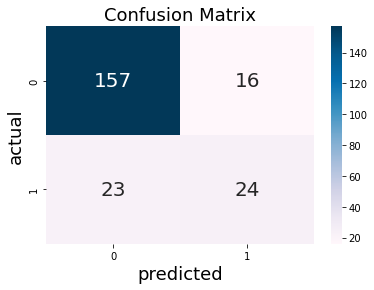

None
Training Accuracy: 0.8736420939923454


Validation Accuracy: 0.8257507198683669


Grid Search Best Params:


{'classifier__max_depth': 6, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [109]:
c_grid_search(RandomForestClassifier(),rand_forest_parms,KFold())



Recall:  0.5319148936170213
Accuracy:  0.7818181818181819
Precision:  0.49019607843137253
F1:  0.5102040816326531


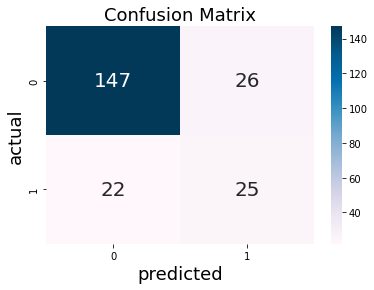

None
Training Accuracy: 0.8693113113576872


Validation Accuracy: 0.8039777869189635


Grid Search Best Params:


{'classifier__colsample_bytree': 0.3, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1}


In [110]:
c_grid_search(XGBClassifier(),xgb_params,KFold())

c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio par



Recall:  0.5957446808510638
Accuracy:  0.6909090909090909
Precision:  0.36363636363636365
F1:  0.4516129032258065


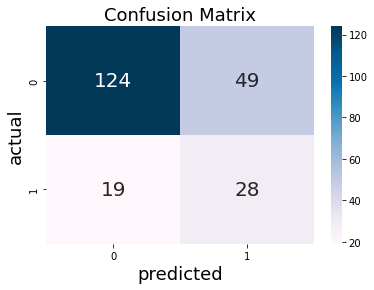

None
Training Accuracy: 0.7327809822377683


Validation Accuracy: 0.713118058412176


Grid Search Best Params:


{'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [111]:
c_grid_search(LogisticRegression(),log_regress_params,KFold())



Recall:  0.574468085106383
Accuracy:  0.7045454545454546
Precision:  0.375
F1:  0.453781512605042


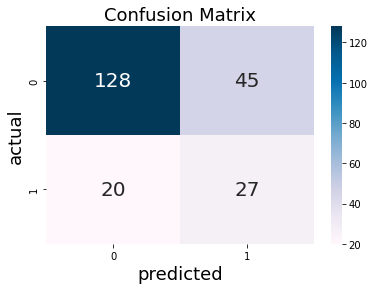

None
Training Accuracy: 1.0


Validation Accuracy: 0.7376881941587824


Grid Search Best Params:


{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}


In [112]:
c_grid_search(KNeighborsClassifier(),knn_params,KFold())